In [1]:
# 图像分析与理解
# 形态学实验 - 二值图像
# 东南大学，卓旭，212138

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [14]:
### Helper Functions ###

def readBinaryImage(path, delim=','):
    trimNotEmpty = lambda x: len(x.strip()) > 0
    with open(path, 'r') as fp:
        content = fp.read()
        
    rows = list(filter(trimNotEmpty, content.replace('\r\n', '\n').split('\n')))
    h = len(rows)
    row = list(filter(trimNotEmpty, rows[0].split(delim)))
    w = len(row)
    content = list(map(int, list(filter(trimNotEmpty, content.replace('\n', ',').split(delim)))))
    
    return np.array(content, dtype=bool).reshape(h, w)

def displayBinaryImage(img, title='', reverseLUT=False):    
    disp = np.array(img, dtype=np.uint8)
    lut = [255, 0] if reverseLUT else [0, 255]
    disp[disp == 0] = lut[0]
    disp[disp == 1] = lut[1]
    
    plt.title(title)
    plt.imshow(disp, cmap='gray', vmin=0, vmax=255)

# These functions suppose that the original point is the center of SE.
# We only consider those points inside the image when SE aligns at the corners or edges.
def erode(img, se):
    # {p | (B)_p \subseteq A}
    h, w = img.shape
    sh, sw = se.shape
    assert sh % 2 == 1 and sw % 2 == 1
    res = np.zeros_like(img)
    
    for i in range(h):
        for j in range(w): # enumerate p
            isValid = True
            for m in range(-sh // 2, sh // 2 + 1):
                for n in range(-sw // 2, sw // 2 + 1):
                    r = i + m; c = j + n
                    pix = True if (r < 0 or r >= h or c < 0 or c >= w) else img[r, c] # assume we pad using True
                    if not pix and se[m + sh // 2, n + sw // 2]:
                        isValid = False
                        break
            res[i, j] = isValid and img[i, j]
    
    return res
    
def dilate(img, se):
    return complement(erode(complement(img), np.flipud(np.fliplr(se))))
    
def open_(img, se):
    # (A - B) + B
    return dilate(erode(img, se), se)

def close(img, se):
    # (A + B) - B
    return erode(dilate(img, se), se)

def complement(img):
    return np.array(np.logical_not(img))
    
def union(a, b):
    assert np.array_equal(a.shape, b.shape)
    return np.logical_or(a, b)

def intersect(a, b):
    assert np.array_equal(a.shape, b.shape)
    return np.logical_and(a, b)

def same(a, b):
    return np.array_equal(a, b)

H, W =  (340, 325)


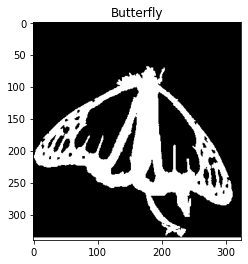

In [4]:
# 1 - 读取butterfly.txt
I0 = readBinaryImage('./data/butterfly.txt')
plt.figure(); displayBinaryImage(I0, 'Butterfly')
print('H, W = ', I0.shape)

(7, 7)

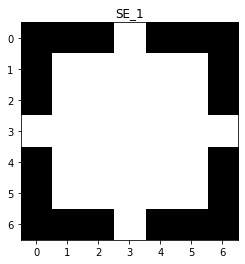

In [5]:
# 2 - 开操作与闭操作
# a) SE开I0
SE_1 = readBinaryImage('./data/se_1.txt')
plt.figure(); displayBinaryImage(SE_1, 'SE_1')
SE_1.shape

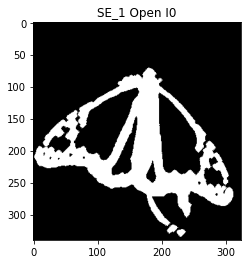

In [6]:
SE_1_Open_I0 = open_(I0, SE_1)
plt.figure(); displayBinaryImage(SE_1_Open_I0, 'SE_1 Open I0')

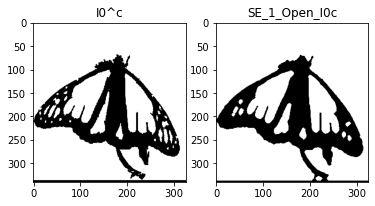

In [7]:
# b) SE开I0^c
I0c = complement(I0)
SE_1_Open_I0c = open_(I0c, SE_1)
plt.figure(); plt.subplot(121); displayBinaryImage(I0c, 'I0^c')
plt.subplot(122); displayBinaryImage(SE_1_Open_I0c, 'SE_1_Open_I0c')

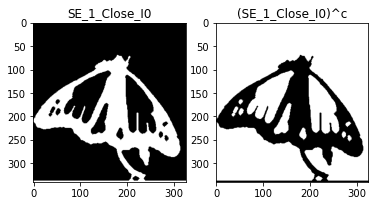

In [8]:
# c) SE闭I0
SE_1_Close_I0 = close(I0, SE_1)
plt.figure(); plt.subplot(121); displayBinaryImage(SE_1_Close_I0, 'SE_1_Close_I0');
plt.subplot(122); displayBinaryImage(complement(SE_1_Close_I0), '(SE_1_Close_I0)^c');

(340, 325)

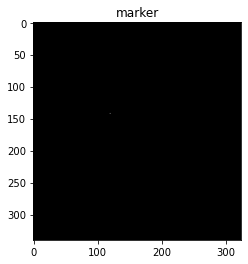

In [12]:
# 3 - 形态学重建
# a)
Im = readBinaryImage('./data/marker.txt')
plt.figure(); displayBinaryImage(Im, 'marker')
Im.shape

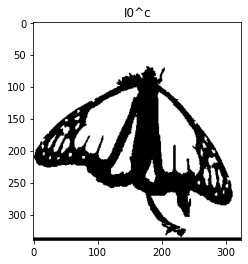

In [13]:
# b)
I0c = complement(I0)
plt.figure(); displayBinaryImage(I0c, 'I0^c')

In [26]:
# c)
Ir = Im
Irs = [np.array(Ir)]
i = 0
while True:
    Ir = intersect(dilate(Ir, SE_1), I0c)
    if same(Ir, Irs[-1]):
        break
    Irs.append(np.array(Ir))
    i += 1
print('Total iter: ', i)

Total iter:  28


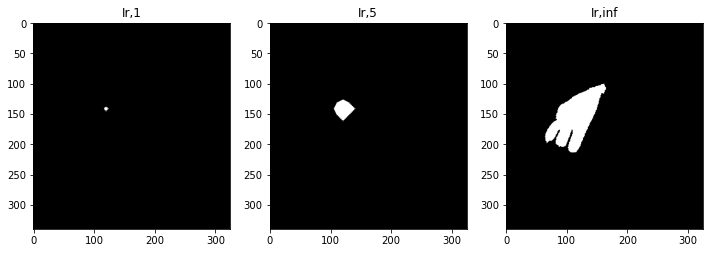

In [29]:
plt.figure(figsize=(12, 8))
plt.subplot(131); displayBinaryImage(Irs[1], 'Ir,1')
plt.subplot(132); displayBinaryImage(Irs[5], 'Ir,5')
plt.subplot(133); displayBinaryImage(Irs[-1], 'Ir,inf')

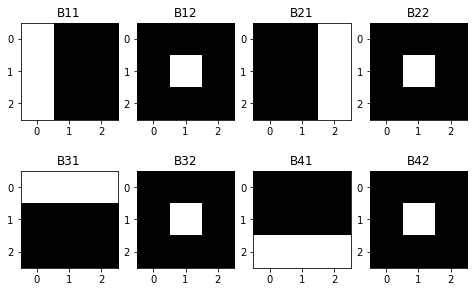

In [75]:
# 4 - Convex Hull
I1 = Irs[-1]
B11 = readBinaryImage('./data/convex_hull_se/B11.txt'); B12 = readBinaryImage('./data/convex_hull_se/B12.txt')
B21 = readBinaryImage('./data/convex_hull_se/B21.txt'); B22 = readBinaryImage('./data/convex_hull_se/B22.txt')
B31 = readBinaryImage('./data/convex_hull_se/B31.txt'); B32 = readBinaryImage('./data/convex_hull_se/B32.txt')
B41 = readBinaryImage('./data/convex_hull_se/B41.txt'); B42 = readBinaryImage('./data/convex_hull_se/B42.txt')
plt.figure(figsize=(8, 5))
plt.subplot(241); displayBinaryImage(B11, 'B11'); plt.subplot(242); displayBinaryImage(B12, 'B12')
plt.subplot(243); displayBinaryImage(B21, 'B21'); plt.subplot(244); displayBinaryImage(B22, 'B22')
plt.subplot(245); displayBinaryImage(B31, 'B31'); plt.subplot(246); displayBinaryImage(B32, 'B32')
plt.subplot(247); displayBinaryImage(B41, 'B41'); plt.subplot(248); displayBinaryImage(B42, 'B42')

In [76]:
def convexHull(img, se1, se2):
    Ich = np.array(img)
    Ichs = [Ich]
    i = 0
    while True:
        A = erode(Ich, se1)
        B = erode(complement(Ich), se2)
        Ich = union(intersect(A, B), img)
        if same(Ich, Ichs[-1]):
            break
        Ichs.append(np.array(Ich))
        i += 1
    return Ichs[-1], i

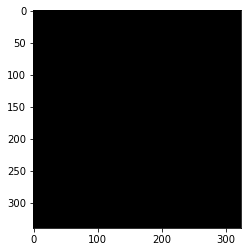

In [77]:
plt.figure()
displayBinaryImage(intersect(erode(I1, B11), erode(complement(I1), B12)))

Total iter:  0


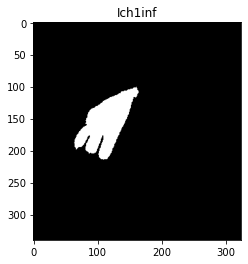

In [78]:
Ich1inf, iter1 = convexHull(I1, B11, B12)
plt.figure(); displayBinaryImage(Ich1inf, 'Ich1inf')
print('Total iter: ', iter1)

Total iter:  0


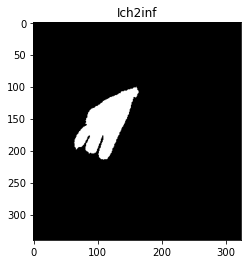

In [79]:
Ich2inf, iter2 = convexHull(I1, B21, B22)
plt.figure(); displayBinaryImage(Ich2inf, 'Ich2inf')
print('Total iter: ', iter2)

Total iter:  0


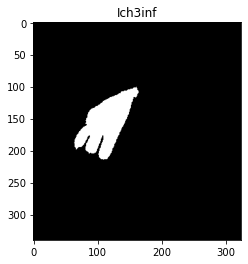

In [80]:
Ich3inf, iter3 = convexHull(I1, B31, B32)
plt.figure(); displayBinaryImage(Ich3inf, 'Ich3inf')
print('Total iter: ', iter3)

Total iter:  0


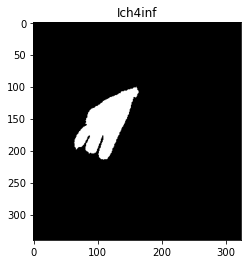

In [81]:
Ich4inf, iter4 = convexHull(I1, B41, B42)
plt.figure(); displayBinaryImage(Ich4inf, 'Ich4inf')
print('Total iter: ', iter4)